In [3]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import models,transforms
import json
import cv2
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class KPdataset(Dataset):
    def __init__(self,img_dir,label_dir):
        self.img_dir = img_dir
        with open(label_dir) as f:
            self.label = json.load(f)

        self.transorms = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225]),

        ])

    def __len__ (self):
        return len(self.label)
    
    def __getitem__(self, index):
        item = self.label[index]
        img = cv2.imread(self.img_dir +"/"+ item['id']+".png")
        #h,w,c
        h,w = img.shape[:2]
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = self.transorms(img)
        keypoints = np.array(item['kps']).flatten() # has to be in numpy 1d array
        keypoints = keypoints.astype('float32')

        #since resezing the image will change the location of keypoints we will have to adjust them
        
        keypoints[::2] *= 224.0/w # changing x coordinates stored at even index
        
        keypoints[1::2] *= 224.0/h #chaning y coordinates stored at all odd index
        return img,keypoints    



In [5]:
df_train = KPdataset("data/images","data/data_train.json")
df_val = KPdataset("data/images","data/data_val.json")

train_loader = DataLoader(df_train,batch_size=16,shuffle=True)
val_loader = DataLoader(df_val,batch_size=16,shuffle=True)

torch.Size([3, 224])
[ 66.15      57.86667  158.375     57.244446  42.35     176.0889
 185.15     175.46667   77.875     57.555557  60.375    176.0889
 146.825     57.555557 167.3      175.46667   74.9       76.844444
 150.15      76.53333   65.975    138.44444  160.825    137.82222
 112.525     76.844444 113.4      138.13333 ]


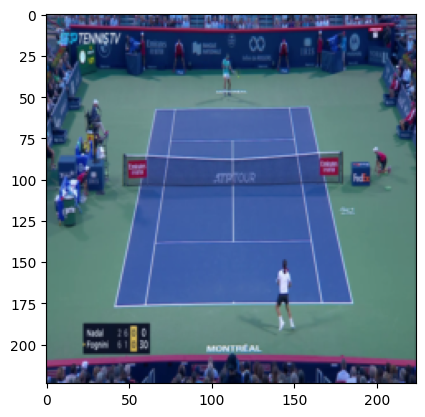

In [6]:
img, keypoints = df_train[0]
print(img.shape[:2])
img = img.permute(1, 2, 0).numpy()
img -= img.min()  # Shift the minimum value to 0
img /= img.max()  # Scale to the range [0, 1]
print(keypoints)
plt.imshow(img)

In [7]:
#Finetuning
model = models.resnet50(weights="IMAGENET1K_V2")
model.fc = torch.nn.Linear(model.fc.in_features,14*2)# 14 pairs of x and y coords

model = model.to(device)

In [8]:
criterion = torch.nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr=0.001) 

In [9]:
epochs = 20
tot_loss =0.0
total_iterations = len(train_loader)
for epoch in range(epochs):
    for i ,(img,keypoints) in tqdm(enumerate(train_loader),total=total_iterations):
        img = img.to(device)
        keypoints = keypoints.to(device)
        
        optim.zero_grad()
        output = model(img)
        loss = criterion(output,keypoints)
        loss.backward()
        optim.step()
        tot_loss += loss.item()
        
        if i%50 ==0:
            print(f"Epoch: {epoch}, iter: ,{i} Loss: {loss.item()},total loss:{tot_loss/total_iterations}: Total iterations left: {total_iterations * (epochs - epoch) - i}")
        # # tqdm.set_postfix({'Loss': loss.item()})
        

    # Print epoch and average loss
        # tqdm.write(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")



  0%|          | 1/415 [00:01<11:39,  1.69s/it]

Epoch: 0, iter: ,0 Loss: 14739.12890625,total loss:35.51597326807229: Total iterations left: 8300


 12%|█▏        | 51/415 [00:50<05:58,  1.01it/s]

Epoch: 0, iter: ,50 Loss: 95.40090942382812,total loss:614.9823712452348: Total iterations left: 8250


 24%|██▍       | 101/415 [01:39<04:57,  1.05it/s]

Epoch: 0, iter: ,100 Loss: 61.54454803466797,total loss:632.4265583819654: Total iterations left: 8200


 36%|███▋      | 151/415 [02:27<04:31,  1.03s/it]

Epoch: 0, iter: ,150 Loss: 66.40061950683594,total loss:642.8368302586567: Total iterations left: 8150


 48%|████▊     | 201/415 [03:27<03:21,  1.06it/s]

Epoch: 0, iter: ,200 Loss: 77.14537811279297,total loss:650.4437374666513: Total iterations left: 8100


 60%|██████    | 251/415 [04:15<02:36,  1.05it/s]

Epoch: 0, iter: ,250 Loss: 48.02620315551758,total loss:660.8974187046648: Total iterations left: 8050


 73%|███████▎  | 301/415 [05:10<02:34,  1.36s/it]

Epoch: 0, iter: ,300 Loss: 86.89380645751953,total loss:669.1212492104037: Total iterations left: 8000


 85%|████████▍ | 351/415 [06:20<01:34,  1.48s/it]

Epoch: 0, iter: ,350 Loss: 33.59812927246094,total loss:674.137705276673: Total iterations left: 7950


 97%|█████████▋| 401/415 [07:41<00:14,  1.03s/it]

Epoch: 0, iter: ,400 Loss: 46.12445831298828,total loss:680.9379039764405: Total iterations left: 7900


  0%|          | 1/415 [00:00<05:41,  1.21it/s]

Epoch: 1, iter: ,0 Loss: 14.354490280151367,total loss:682.964646226814: Total iterations left: 7885


 12%|█▏        | 51/415 [00:53<05:09,  1.17it/s]

Epoch: 1, iter: ,50 Loss: 13.361082077026367,total loss:686.8734203775246: Total iterations left: 7835


 24%|██▍       | 101/415 [01:36<04:28,  1.17it/s]

Epoch: 1, iter: ,100 Loss: 12.993902206420898,total loss:691.4537970554397: Total iterations left: 7785


 36%|███▋      | 151/415 [02:18<03:45,  1.17it/s]

Epoch: 1, iter: ,150 Loss: 14.902708053588867,total loss:695.379994374011: Total iterations left: 7735


 48%|████▊     | 201/415 [03:00<03:00,  1.19it/s]

Epoch: 1, iter: ,200 Loss: 9.634840965270996,total loss:698.1384671659355: Total iterations left: 7685


 60%|██████    | 251/415 [03:43<02:20,  1.17it/s]

Epoch: 1, iter: ,250 Loss: 10.36106014251709,total loss:701.1060331022883: Total iterations left: 7635


 73%|███████▎  | 301/415 [04:26<01:40,  1.13it/s]

Epoch: 1, iter: ,300 Loss: 10.745387077331543,total loss:703.6464103193168: Total iterations left: 7585


 85%|████████▍ | 351/415 [05:22<01:32,  1.45s/it]

Epoch: 1, iter: ,350 Loss: 18.08833885192871,total loss:706.1732288866158: Total iterations left: 7535


 97%|█████████▋| 401/415 [06:33<00:19,  1.42s/it]

Epoch: 1, iter: ,400 Loss: 18.560888290405273,total loss:708.5376284426953: Total iterations left: 7485


  0%|          | 1/415 [00:00<06:05,  1.13it/s]

Epoch: 2, iter: ,0 Loss: 19.034687042236328,total loss:709.5343408320324: Total iterations left: 7470


 12%|█▏        | 51/415 [00:43<05:04,  1.19it/s]

Epoch: 2, iter: ,50 Loss: 11.47033977508545,total loss:711.3564583404955: Total iterations left: 7420


 24%|██▍       | 101/415 [01:26<04:38,  1.13it/s]

Epoch: 2, iter: ,100 Loss: 12.315564155578613,total loss:713.4979019768267: Total iterations left: 7370


 36%|███▋      | 151/415 [02:09<03:43,  1.18it/s]

Epoch: 2, iter: ,150 Loss: 8.357876777648926,total loss:715.3349602986531: Total iterations left: 7320


 48%|████▊     | 201/415 [02:52<03:01,  1.18it/s]

Epoch: 2, iter: ,200 Loss: 12.623181343078613,total loss:717.8727261244533: Total iterations left: 7270


 60%|██████    | 251/415 [03:40<04:16,  1.56s/it]

Epoch: 2, iter: ,250 Loss: 10.319806098937988,total loss:719.4609812702041: Total iterations left: 7220


 73%|███████▎  | 301/415 [04:58<02:55,  1.54s/it]

Epoch: 2, iter: ,300 Loss: 28.747529983520508,total loss:723.5111711444625: Total iterations left: 7170


 85%|████████▍ | 351/415 [06:16<01:41,  1.58s/it]

Epoch: 2, iter: ,350 Loss: 9.819136619567871,total loss:725.6800641209246: Total iterations left: 7120


 97%|█████████▋| 401/415 [07:37<00:22,  1.61s/it]

Epoch: 2, iter: ,400 Loss: 12.335979461669922,total loss:728.4999240157116: Total iterations left: 7070


  0%|          | 1/415 [00:01<11:22,  1.65s/it]

Epoch: 3, iter: ,0 Loss: 156.19419860839844,total loss:730.3233266491487: Total iterations left: 7055


 12%|█▏        | 51/415 [01:22<09:56,  1.64s/it]

Epoch: 3, iter: ,50 Loss: 14.062371253967285,total loss:736.4792508395321: Total iterations left: 7005


 24%|██▍       | 101/415 [02:06<04:30,  1.16it/s]

Epoch: 3, iter: ,100 Loss: 130.04747009277344,total loss:739.3626924359655: Total iterations left: 6955


 36%|███▋      | 151/415 [02:56<06:48,  1.55s/it]

Epoch: 3, iter: ,150 Loss: 10.078325271606445,total loss:741.7225366460272: Total iterations left: 6905


 48%|████▊     | 201/415 [04:17<05:46,  1.62s/it]

Epoch: 3, iter: ,200 Loss: 13.502339363098145,total loss:743.4057564936488: Total iterations left: 6855


 60%|██████    | 251/415 [05:10<02:20,  1.17it/s]

Epoch: 3, iter: ,250 Loss: 37.69964599609375,total loss:746.1746978294418: Total iterations left: 6805


 73%|███████▎  | 301/415 [05:54<01:38,  1.15it/s]

Epoch: 3, iter: ,300 Loss: 18.73772621154785,total loss:748.7828615814807: Total iterations left: 6755


 85%|████████▍ | 351/415 [06:37<00:54,  1.17it/s]

Epoch: 3, iter: ,350 Loss: 53.384517669677734,total loss:750.4376562457487: Total iterations left: 6705


 97%|█████████▋| 401/415 [07:39<00:21,  1.57s/it]

Epoch: 3, iter: ,400 Loss: 15.010762214660645,total loss:752.0894876066461: Total iterations left: 6655


  0%|          | 1/415 [00:01<11:31,  1.67s/it]

Epoch: 4, iter: ,0 Loss: 67.97200775146484,total loss:753.7445470844407: Total iterations left: 6640


 12%|█▏        | 51/415 [01:20<09:53,  1.63s/it]

Epoch: 4, iter: ,50 Loss: 13.855340957641602,total loss:756.9885629722871: Total iterations left: 6590


 24%|██▍       | 101/415 [02:40<08:22,  1.60s/it]

Epoch: 4, iter: ,100 Loss: 14.768776893615723,total loss:758.6712675858693: Total iterations left: 6540


 36%|███▋      | 151/415 [04:00<06:57,  1.58s/it]

Epoch: 4, iter: ,150 Loss: 4.102751731872559,total loss:760.2473125503724: Total iterations left: 6490


 48%|████▊     | 201/415 [05:14<05:13,  1.47s/it]

Epoch: 4, iter: ,200 Loss: 7.379964828491211,total loss:761.7018035980592: Total iterations left: 6440


 60%|██████    | 251/415 [06:37<05:07,  1.87s/it]

Epoch: 4, iter: ,250 Loss: 9.784282684326172,total loss:763.1204702831176: Total iterations left: 6390


 73%|███████▎  | 301/415 [08:18<03:37,  1.91s/it]

Epoch: 4, iter: ,300 Loss: 42.18693161010742,total loss:765.2287166951651: Total iterations left: 6340


 85%|████████▍ | 351/415 [09:46<01:40,  1.57s/it]

Epoch: 4, iter: ,350 Loss: 5.813254356384277,total loss:766.3175399096615: Total iterations left: 6290


 97%|█████████▋| 401/415 [11:02<00:20,  1.45s/it]

Epoch: 4, iter: ,400 Loss: 4.110393524169922,total loss:768.0186069890677: Total iterations left: 6240


  0%|          | 1/415 [00:01<10:53,  1.58s/it]

Epoch: 5, iter: ,0 Loss: 6.115732669830322,total loss:768.227805976408: Total iterations left: 6225


 12%|█▏        | 51/415 [01:02<05:13,  1.16it/s]

Epoch: 5, iter: ,50 Loss: 24.3958683013916,total loss:770.0056225187807: Total iterations left: 6175


 24%|██▍       | 101/415 [01:46<04:26,  1.18it/s]

Epoch: 5, iter: ,100 Loss: 10.4031982421875,total loss:771.3140368128397: Total iterations left: 6125


 36%|███▋      | 151/415 [02:29<03:49,  1.15it/s]

Epoch: 5, iter: ,150 Loss: 3.8281049728393555,total loss:772.3644901962166: Total iterations left: 6075


 48%|████▊     | 201/415 [03:12<03:05,  1.15it/s]

Epoch: 5, iter: ,200 Loss: 1.465636134147644,total loss:772.9132129063089: Total iterations left: 6025


 60%|██████    | 251/415 [03:56<02:23,  1.14it/s]

Epoch: 5, iter: ,250 Loss: 3.7976765632629395,total loss:773.6275068372129: Total iterations left: 5975


 73%|███████▎  | 301/415 [04:39<01:37,  1.18it/s]

Epoch: 5, iter: ,300 Loss: 2.5922043323516846,total loss:774.826391435244: Total iterations left: 5925


 85%|████████▍ | 351/415 [05:22<00:55,  1.16it/s]

Epoch: 5, iter: ,350 Loss: 3.2715392112731934,total loss:775.5358314198184: Total iterations left: 5875


 97%|█████████▋| 401/415 [06:06<00:12,  1.14it/s]

Epoch: 5, iter: ,400 Loss: 2.632840394973755,total loss:776.4511843593724: Total iterations left: 5825


  0%|          | 1/415 [00:00<06:19,  1.09it/s]

Epoch: 6, iter: ,0 Loss: 4.160833358764648,total loss:776.6715891882598: Total iterations left: 5810


 12%|█▏        | 51/415 [01:13<09:10,  1.51s/it]

Epoch: 6, iter: ,50 Loss: 7.444329261779785,total loss:777.3303384779448: Total iterations left: 5760


 24%|██▍       | 101/415 [02:29<07:50,  1.50s/it]

Epoch: 6, iter: ,100 Loss: 2.324554204940796,total loss:777.9807843252837: Total iterations left: 5710


 36%|███▋      | 151/415 [03:46<06:43,  1.53s/it]

Epoch: 6, iter: ,150 Loss: 5.632523059844971,total loss:778.6169830320829: Total iterations left: 5660


 48%|████▊     | 201/415 [05:04<05:23,  1.51s/it]

Epoch: 6, iter: ,200 Loss: 71.1892318725586,total loss:779.8785275699145: Total iterations left: 5610


 60%|██████    | 251/415 [06:26<04:36,  1.68s/it]

Epoch: 6, iter: ,250 Loss: 2.4638171195983887,total loss:780.8655756460615: Total iterations left: 5560


 73%|███████▎  | 301/415 [07:32<02:30,  1.32s/it]

Epoch: 6, iter: ,300 Loss: 6.917047023773193,total loss:781.6748183843602: Total iterations left: 5510


 85%|████████▍ | 351/415 [08:41<01:29,  1.39s/it]

Epoch: 6, iter: ,350 Loss: 6.408750534057617,total loss:782.649978506565: Total iterations left: 5460


 97%|█████████▋| 401/415 [09:52<00:19,  1.42s/it]

Epoch: 6, iter: ,400 Loss: 1.6742783784866333,total loss:783.30166014318: Total iterations left: 5410


  0%|          | 1/415 [00:01<08:58,  1.30s/it]

Epoch: 7, iter: ,0 Loss: 1.8850890398025513,total loss:783.4522402873959: Total iterations left: 5395


 12%|█▏        | 51/415 [01:10<07:00,  1.15s/it]

Epoch: 7, iter: ,50 Loss: 1.3476685285568237,total loss:784.1761842085655: Total iterations left: 5345


 24%|██▍       | 101/415 [02:02<04:30,  1.16it/s]

Epoch: 7, iter: ,100 Loss: 4.443893909454346,total loss:784.9515847624066: Total iterations left: 5295


 36%|███▋      | 151/415 [02:45<03:50,  1.15it/s]

Epoch: 7, iter: ,150 Loss: 1.403440237045288,total loss:785.4104772024845: Total iterations left: 5245


 48%|████▊     | 201/415 [03:29<03:04,  1.16it/s]

Epoch: 7, iter: ,200 Loss: 15.304744720458984,total loss:786.5479374756296: Total iterations left: 5195


 60%|██████    | 251/415 [04:13<02:25,  1.13it/s]

Epoch: 7, iter: ,250 Loss: 1.9747527837753296,total loss:787.0464662791735: Total iterations left: 5145


 73%|███████▎  | 301/415 [04:58<01:43,  1.11it/s]

Epoch: 7, iter: ,300 Loss: 2.1587486267089844,total loss:787.8933151749243: Total iterations left: 5095


 85%|████████▍ | 351/415 [05:43<00:57,  1.11it/s]

Epoch: 7, iter: ,350 Loss: 1.741817593574524,total loss:788.5004842940583: Total iterations left: 5045


 97%|█████████▋| 401/415 [06:28<00:12,  1.15it/s]

Epoch: 7, iter: ,400 Loss: 94.52808380126953,total loss:789.1118307284562: Total iterations left: 4995


  0%|          | 1/415 [00:00<06:04,  1.13it/s]

Epoch: 8, iter: ,0 Loss: 4.63053035736084,total loss:789.5553319165506: Total iterations left: 4980


 12%|█▏        | 51/415 [00:44<05:17,  1.15it/s]

Epoch: 8, iter: ,50 Loss: 4.0076751708984375,total loss:790.3125988634235: Total iterations left: 4930


 24%|██▍       | 101/415 [01:29<04:40,  1.12it/s]

Epoch: 8, iter: ,100 Loss: 3.7200264930725098,total loss:790.9822642870696: Total iterations left: 4880


 36%|███▋      | 151/415 [02:14<04:02,  1.09it/s]

Epoch: 8, iter: ,150 Loss: 42.49608612060547,total loss:791.5131375319986: Total iterations left: 4830


 48%|████▊     | 201/415 [02:59<03:13,  1.11it/s]

Epoch: 8, iter: ,200 Loss: 4.221595287322998,total loss:792.2981731568474: Total iterations left: 4780


 60%|██████    | 251/415 [03:44<02:26,  1.12it/s]

Epoch: 8, iter: ,250 Loss: 2.2641992568969727,total loss:793.1205179273364: Total iterations left: 4730


 73%|███████▎  | 301/415 [04:28<01:39,  1.15it/s]

Epoch: 8, iter: ,300 Loss: 2.781543016433716,total loss:794.0535379020564: Total iterations left: 4680


 85%|████████▍ | 351/415 [05:11<00:54,  1.18it/s]

Epoch: 8, iter: ,350 Loss: 8.752105712890625,total loss:794.6649573206902: Total iterations left: 4630


 97%|█████████▋| 401/415 [05:58<00:12,  1.16it/s]

Epoch: 8, iter: ,400 Loss: 2.2056407928466797,total loss:795.5852544016149: Total iterations left: 4580


  0%|          | 1/415 [00:00<05:58,  1.16it/s]

Epoch: 9, iter: ,0 Loss: 2.4904708862304688,total loss:795.9664528354105: Total iterations left: 4565


 12%|█▏        | 51/415 [00:44<05:18,  1.14it/s]

Epoch: 9, iter: ,50 Loss: 4.396983623504639,total loss:796.3297960706504: Total iterations left: 4515


 24%|██▍       | 101/415 [01:27<04:36,  1.13it/s]

Epoch: 9, iter: ,100 Loss: 3.4137156009674072,total loss:796.9569089195815: Total iterations left: 4465


 36%|███▋      | 151/415 [02:11<03:49,  1.15it/s]

Epoch: 9, iter: ,150 Loss: 1.735872745513916,total loss:797.4726196636636: Total iterations left: 4415


 48%|████▊     | 201/415 [02:54<03:07,  1.14it/s]

Epoch: 9, iter: ,200 Loss: 6.301327228546143,total loss:798.3138821698096: Total iterations left: 4365


 60%|██████    | 251/415 [03:37<02:24,  1.13it/s]

Epoch: 9, iter: ,250 Loss: 3.3651394844055176,total loss:799.0303806803313: Total iterations left: 4315


 73%|███████▎  | 301/415 [04:20<01:38,  1.16it/s]

Epoch: 9, iter: ,300 Loss: 1.3487622737884521,total loss:799.4887133079839: Total iterations left: 4265


 85%|████████▍ | 351/415 [05:03<00:56,  1.14it/s]

Epoch: 9, iter: ,350 Loss: 3.710399866104126,total loss:800.4580206899758: Total iterations left: 4215


 97%|█████████▋| 401/415 [05:51<00:11,  1.17it/s]

Epoch: 9, iter: ,400 Loss: 2.7842531204223633,total loss:801.2329054240721: Total iterations left: 4165


  0%|          | 1/415 [00:00<05:47,  1.19it/s]

Epoch: 10, iter: ,0 Loss: 2.898697853088379,total loss:801.4185040873217: Total iterations left: 4150


 12%|█▏        | 51/415 [01:07<09:07,  1.50s/it]

Epoch: 10, iter: ,50 Loss: 1.4381606578826904,total loss:801.8055437138281: Total iterations left: 4100


 24%|██▍       | 101/415 [02:21<07:43,  1.48s/it]

Epoch: 10, iter: ,100 Loss: 1.2382408380508423,total loss:802.2198976294104: Total iterations left: 4050


 36%|███▋      | 151/415 [03:35<06:32,  1.49s/it]

Epoch: 10, iter: ,150 Loss: 2.40636944770813,total loss:803.1305786441608: Total iterations left: 4000


 48%|████▊     | 201/415 [04:50<05:14,  1.47s/it]

Epoch: 10, iter: ,200 Loss: 89.14472961425781,total loss:803.8195017296148: Total iterations left: 3950


 60%|██████    | 251/415 [06:04<03:55,  1.44s/it]

Epoch: 10, iter: ,250 Loss: 4.054998874664307,total loss:804.7960566160191: Total iterations left: 3900


 73%|███████▎  | 301/415 [07:11<02:04,  1.09s/it]

Epoch: 10, iter: ,300 Loss: 1.2492382526397705,total loss:805.4125139980431: Total iterations left: 3850


 85%|████████▍ | 351/415 [08:00<00:57,  1.10it/s]

Epoch: 10, iter: ,350 Loss: 3.058811664581299,total loss:806.0657723235797: Total iterations left: 3800


 97%|█████████▋| 401/415 [08:44<00:12,  1.15it/s]

Epoch: 10, iter: ,400 Loss: 1.04903244972229,total loss:806.4428333092885: Total iterations left: 3750


  0%|          | 1/415 [00:00<06:08,  1.12it/s]

Epoch: 11, iter: ,0 Loss: 1.686919093132019,total loss:806.5411258049758: Total iterations left: 3735


 12%|█▏        | 51/415 [00:44<05:25,  1.12it/s]

Epoch: 11, iter: ,50 Loss: 1.2761383056640625,total loss:807.0164195719972: Total iterations left: 3685


 14%|█▍        | 60/415 [00:53<05:17,  1.12it/s]


KeyboardInterrupt: 

In [10]:
torch.save(model.state_dict(),"keypoints_model.pth")